## Assignment 3

## Instructions
* This is an individual assignment. You are not allowed to discuss the problems with other students.

* Parts of this assignment will be autograded by gradescope. You can use it as immediate feedback to improve your answers. You can resubmit as many times as you want. Please also note that the **public tests are not exhaustive**, meaning that passing the public tests does not necessarily imply that your implementation is correct. It is recommended to test your implementation in your own ways instead of solely relying on the autograder.

* All your solution, code, analysis, graphs, and explanations should be done in this same notebook.

* Please make sure to execute all the cells before you submit the notebook to the gradescope. You will not get points for the plots if they are not generated already.

* If you have questions regarding the assignment, you can ask for clarifications in Piazza. You should use the corresponding tag for this assignment.

* Make sure to use Google Colab to avoid unnecessary issues. If you are having issues with Colab, try to restart your runtime ( Runtime -> Restart runtime ) and see if the issues persist.

**Warning:** For this assignment, you are free to use libraries with general utilities, such as *numpy* and *pandas*, and you are expected to use pre-existing implementation of the algorithms available in *scikit-learn*.

**When Submitting to GradeScope**: Be sure to
1) Submit a `.ipynb` notebook to the `Assignment 3 - Programming` section on Gradescope.
2) Submit a `pdf` version of the notebook to the `Assignment 3 - Analysis` entry. This should be the version of the `.ipynb` notebook with all the cells executed and corresponding graphs generated.

## Getting Started

In this assignment, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

The next two cells install and initialize otter-grader. You should run these cells as they are WITHOUT modifying them!

In [16]:
!pip install otter-grader
!git clone https://github.com/chandar-lab/INF8245e-assignments-2023.git public

fatal: destination path 'public' already exists and is not an empty directory.


In [17]:
%cd ./public/a3

c:\Users\lomin\OneDrive\Desktop\ML_assignments\A3\public\a3\public\a3


In [18]:
# Initialize Otter
import otter
grader = otter.Notebook(colab=True, tests_dir='./tests')

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [19]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("./data/census.csv")

# Success - Display the first record
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Question 1: Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted.

In [20]:
def data_exploration(data):
    """
    Calculate the above described statistics of the data provided and return them in the same order.
    Input: data (pd.DataFrame)
    Output: (n_records, n_greater_50k, n_at_most_50k, greater_percent) -> Tuple of integers
    """
    n_records = data.shape[0]
    n_greater_50k = len(data[data['income'] == '>50K'])
    n_at_most_50k = len(data[data['income'] == '<=50K'])
    greater_percent = (n_greater_50k / n_records) * 100
    return n_records, n_greater_50k, n_at_most_50k, greater_percent

In [21]:
grader.check("q1.1")

q1.1 results: All test cases passed!

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`.

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

c:\Users\lomin\OneDrive\Desktop\ML_assignments\A3\public\a3\public\a3\visuals.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


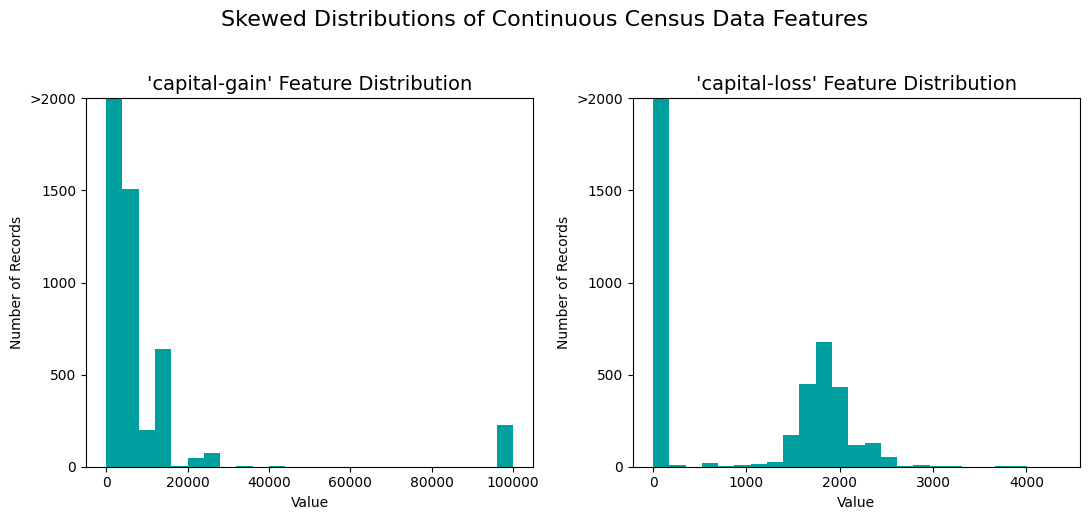

In [22]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully. Use `np.log` for logarithmic transformation.

Implement and run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed.

In [23]:
def log_transform(features_raw):
    """
    Take the data and Log-transform the skewed features
    Input: features_raw (pd.DataFrame)
    Output: features_log_transformed (pd.DataFrame)
    """
    small_amount_above_0 = 1
    features_log_transformed = features_raw.copy()
    features_log_transformed['capital-gain'] = features_log_transformed['capital-gain'].apply(lambda x: np.log(x + small_amount_above_0))
    features_log_transformed['capital-loss'] = features_log_transformed['capital-loss'].apply(lambda x: np.log(x + small_amount_above_0))

    return features_log_transformed

In [24]:
grader.check("q2.1")

q2.1 results: All test cases passed!

c:\Users\lomin\OneDrive\Desktop\ML_assignments\A3\public\a3\public\a3\visuals.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


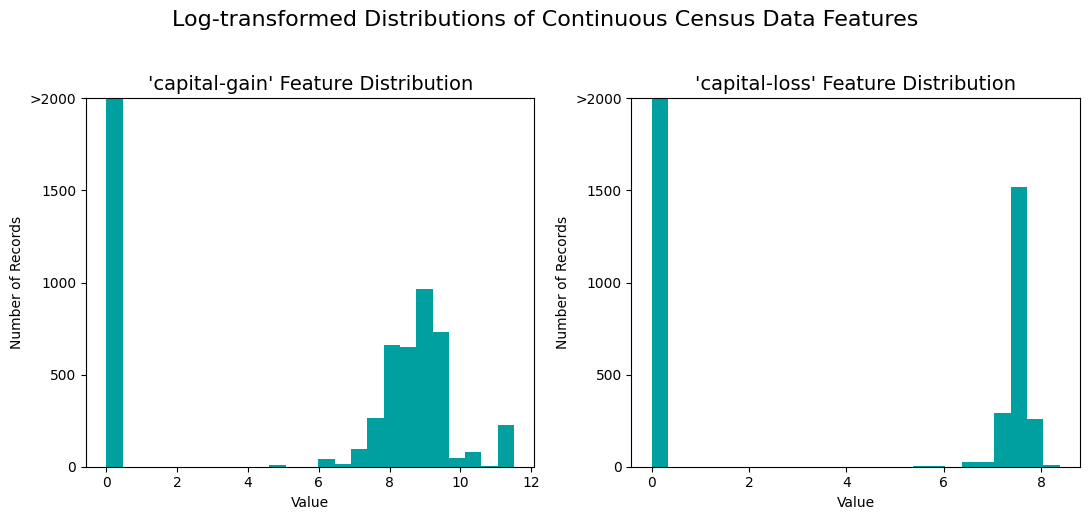

In [25]:
# Visualize the new log distributions
vs.distribution(log_transform(features_raw), transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Implement and run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [26]:
# Import sklearn.preprocessing.StandardScaler
import sklearn
from sklearn.preprocessing import MinMaxScaler

In [27]:
def normalize_features(features_raw):
    """
    Take the input data and normalize the categorical features.
    Input: features_raw (pd.DataFrame)
    Output: features_log_minmax_transform (pd.DataFrame)
    """
    features_log_transformed = log_transform(features_raw)

    numerical_columns = features_log_transformed.select_dtypes(include=[np.number]).columns
    features_numerical = features_log_transformed[numerical_columns]
    scaler = MinMaxScaler()
    features_minmax_transformed = pd.DataFrame(scaler.fit_transform(features_numerical), columns=numerical_columns)
    features_non_numerical = features_raw.drop(columns=numerical_columns)
    features_log_minmax_transform = pd.concat([features_minmax_transformed, features_non_numerical], axis=1)

    return features_log_minmax_transform

features_log_minmax_transform = normalize_features(features_raw)

In [28]:
grader.check("q3.1")

q3.1 results: All test cases passed!

In [29]:
# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass,education_level,marital-status,occupation,relationship,race,sex,native-country
0,0.301370,0.800000,0.667492,0.0,0.397959,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,0.452055,0.800000,0.000000,0.0,0.122449,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,0.287671,0.533333,0.000000,0.0,0.397959,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,0.493151,0.400000,0.000000,0.0,0.397959,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,0.150685,0.800000,0.000000,0.0,0.397959,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [30]:
def one_hot_encoding(features_log_minmax_transform):
    """
    One-hot encode the 'features_log_minmax_transform'.
    Input: features_log_minmax_transform (pd.DataFrame)
    Output: features_final (pd.DataFrame)
    """
    features_final = pd.get_dummies(features_log_minmax_transform)
    return  features_final

In [31]:
grader.check("q4.1")

q4.1 results: All test cases passed!

In [32]:
def encode_label(income_raw):
    """
    Encode the 'income_raw' data to numerical values.
    Input: income_raw (pd.DataFrame)
    Output: income (pd.DataFrame)
    """
    income = income_raw.map({'<=50K': 0, '>50K': 1})
    return income

In [33]:
grader.check("q4.2")

q4.2 results: All test cases passed!

In [34]:
features_final = one_hot_encoding(features_log_minmax_transform)
income = encode_label(income_raw)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Implement and run the code cells below to perform this split. Please use the random state of `0` in the `train_test_split`.

In [35]:
# Import train_test_split
from sklearn.model_selection import train_test_split

In [36]:
def data_splits(features_final, income):
    """
    Split the 'features' and 'income' data into training and testing sets.
    Input(s): features_final (pd.DataFrame), income (pd.DataFrame)
    Output(s): X_train, X_test, y_train, y_test
    """
    # Use random_state = 0 in the train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_splits(features_final, income)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


In [37]:
grader.check("q5")

q5 results: All test cases passed!

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most
\$$50,000$ and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors.


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: **

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total.
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

Implement and evaluate naive predictor on the above mentioned metrics in the code cell below.

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [39]:
def naive_predictor(income):
    """
    Compute the Accuracy, Precision and Recall of a Naive Predictor based on a model that always predicts the individual to make more than $50,000.
    """

    income_new=income.apply(lambda x:1)
    income_new[0]

    ### Follow the structure below

    # # TODO: Calculate the False Negatives, True Positives and False Positives
    FN= 0
    TP= np.sum(income)
    FP= income.count() - TP


    # # TODO: Calculate accuracy, precision and recall
    accuracy = TP / len(income)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)

    # # # # TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
    beta = 0.5
    fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

    print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

    return fscore

naive_predictor(income)
accuracy = 0.2478
fscore = 0.2917

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


In [40]:
grader.check("q6")

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


q6 results: All test cases passed!

###  Supervised Learning Models
**The following are the supervised learning models that you are required to experiment with in this assignment:**
- Decision Trees
- Ensemble Methods (Bagging, *AdaBoost*, Random Forest, Gradient Boosting)
- Support Vector Machines (SVM)

### Question 2 - Model Application


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

<!-- BEGIN QUESTION -->



In [41]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score


def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    beta=0.5
    results = {}

    start = time() # Get start time
    #learner.fit(X_train[:300], y_train[:300])
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time

    results['train_time'] = end-start

    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time

    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start

    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)

    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)

    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)

    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)

    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))

    # Return the results
    return results

<!-- END QUESTION -->

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

<!-- BEGIN QUESTION -->



DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


c:\Users\lomin\OneDrive\Desktop\ML_assignments\A3\public\a3\public\a3\visuals.py:119: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


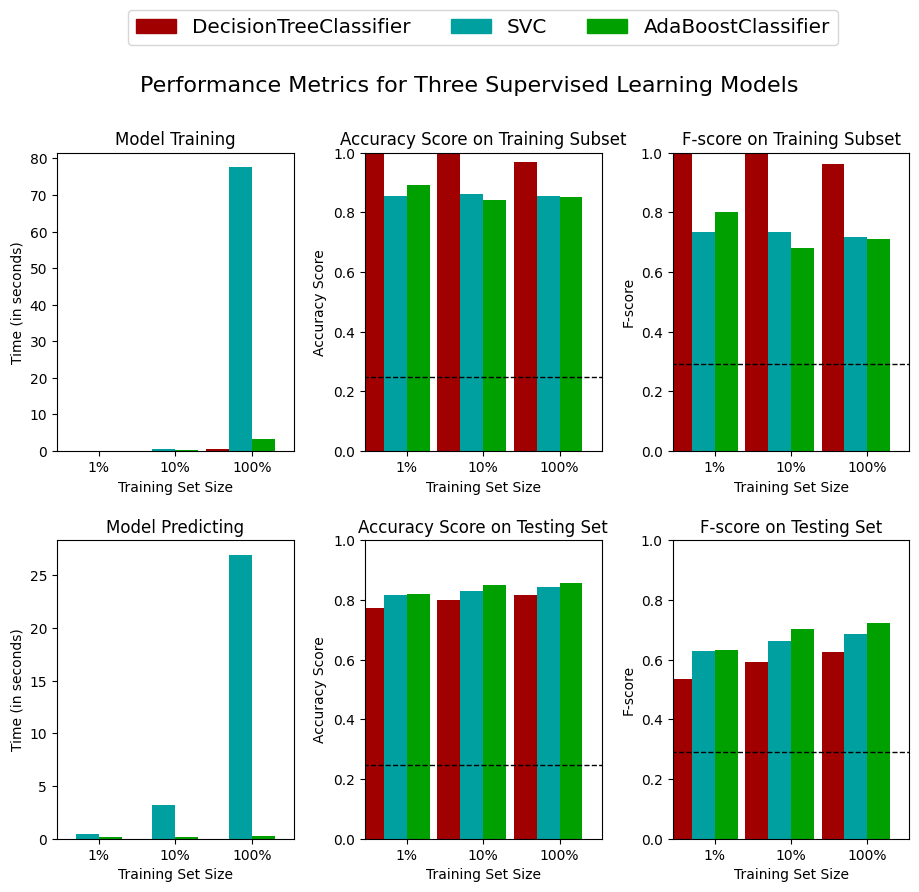

In [42]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# TODO: Initialize the three models
clf_A = DecisionTreeClassifier(random_state=0)
clf_B = SVC(random_state=0)
clf_C = AdaBoostClassifier(random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(0.1 * len(y_train))
samples_1 = int(0.01 * len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

<!-- END QUESTION -->

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score.

### Question 3 - Choosing the Best Model

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

<!-- BEGIN QUESTION -->



In [44]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,fbeta_score
from sklearn.ensemble import AdaBoostClassifier


# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {  'n_estimators': [50, 100, 150],
                'learning_rate': [0.1, 0.5, 0.7],
                'estimator': [DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=None)]
    }

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=clf, scoring=scorer, n_jobs=-1, param_grid=parameters)



# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)
clf.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and best model
predictions = clf.predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8690
Final F-score on the testing data: 0.7489


<!-- END QUESTION -->

### Question 4 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data?
* Are these scores better or worse than the unoptimized model?
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

<!-- BEGIN QUESTION -->

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: |
| Accuracy Score |    85.76 %       |      86.90 %     |
| F-score        |      72.46 %       |      74.89 %     |


**Answer: **

* My optimized model accuracy is 86.9% and the F-score is 74.89% on the testing data.  
* These scores are better than the unoptimized model
* Naive Predictor Accuracy: 24.78% vs. Optimized Model Accuracy: 86.90%  
Naive Predictor F-score: 29.17% vs. Optimized Model F-score: 74.89%

In summary, the optimized model demonstrates substantial improvement over both the unoptimized model and the naive predictor benchmarks

<!-- END QUESTION -->

